In [1]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = './'

In [2]:
# DOWNLOAD DATASET DARI KAGGLE
# !kaggle datasets download -d shubhamgoel27/dermnet
# !kaggle datasets download -d artakusuma/basedir
# !kaggle datasets download -d haroonalam16/20-skin-diseases-dataset
# !kaggle datasets download -d syedalinaqvi/augmented-skin-conditions-image-dataset

In [3]:
import zipfile

# Ekstrak dermnet.zip
# with zipfile.ZipFile("20-skin-diseases-dataset.zip", 'r') as zip_ref:
#     zip_ref.extractall("Datasetnya")

# Tampilkan isi folder "dataset"
print("Isi folder datasetnya:", os.listdir("DATASET"))

Isi folder datasetnya: ['train', 'test']


In [4]:
#LIBRARIES

import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings(action="ignore")
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from keras.models import Model, Sequential
from keras.layers import Dense, Dropout, Flatten, Concatenate, Input, BatchNormalization, GlobalAveragePooling2D, Reshape, Multiply
from keras.applications import VGG19, ResNet101, MobileNetV2, EfficientNetV2B0, DenseNet201
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping, CSVLogger
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import datetime

2024-12-11 12:47:05.048593: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-11 12:47:05.066095: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733896025.086130 1239908 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733896025.092077 1239908 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-11 12:47:05.113168: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [5]:
# from tensorflow.keras import mixed_precision

# # Enable mixed precision
# policy = mixed_precision.Policy('mixed_float16')
# mixed_precision.set_global_policy(policy)

In [6]:
# Definisikan path untuk dataset
base_dir = os.path.join(os.getcwd(), 'DATASET')
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

In [7]:
# Mendapatkan daftar kelas dari folder train
classes = os.listdir(train_dir)

print("Kelas yang ditemukan:", classes)

Kelas yang ditemukan: ['Eczema', 'Melanoma', 'Keratosis', 'Rosacea', 'Carcinoma', 'Ringworm', 'Milia', 'Acne', 'Basal Cell Carcinoma', 'Vitiligo']


In [8]:
# Menghitung jumlah gambar per kelas
train_counts = {}
test_counts = {}

In [9]:
# Hitung jumlah gambar training
for cls in classes:
    train_class_dir = os.path.join(train_dir, cls)
    train_counts[cls] = len(os.listdir(train_class_dir))

# Hitung jumlah gambar testing
test_dir = os.path.join(base_dir, 'test')
for cls in classes:
    test_class_dir = os.path.join(test_dir, cls)
    test_counts[cls] = len(os.listdir(test_class_dir))

In [10]:
# Tampilkan informasi dataset
print(f"Jumlah kelas: {len(classes)}")
print("\nDaftar kelas dan jumlah gambar:")
for cls in classes:
    print(f"{cls}:")
    print(f"- Training: {train_counts[cls]}")
    print(f"- Testing: {test_counts[cls]}")

print(f"\nTotal gambar training: {sum(train_counts.values())}")
print(f"Total gambar testing: {sum(test_counts.values())}")

Jumlah kelas: 10

Daftar kelas dan jumlah gambar:
Eczema:
- Training: 323
- Testing: 76
Melanoma:
- Training: 98
- Testing: 26
Keratosis:
- Training: 328
- Testing: 71
Rosacea:
- Training: 37
- Testing: 37
Carcinoma:
- Training: 316
- Testing: 83
Ringworm:
- Training: 94
- Testing: 13
Milia:
- Training: 319
- Testing: 80
Acne:
- Training: 879
- Testing: 48
Basal Cell Carcinoma:
- Training: 88
- Testing: 37
Vitiligo:
- Training: 295
- Testing: 73

Total gambar training: 2777
Total gambar testing: 544


In [11]:
# Data Generator untuk Training dengan Augmentasi Canggih
train_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=False,
    fill_mode='nearest',               
    validation_split=0.2  # Untuk membagi data
)

# Data Generator untuk Validasi (Minimal Augmentasi)
test_datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet_v2.preprocess_input,
)

# Load training data
train_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),  
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='training', 
    shuffle=True
)

# Load validation data
validation_generator = train_datagen.flow_from_directory(
    os.path.join(base_dir, 'train'),  
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    subset='validation',  
    shuffle=False
)

# Load testing data (tanpa subset karena ini hanya untuk testing)
test_generator = test_datagen.flow_from_directory(
    os.path.join(base_dir, 'test'),  
    target_size=(224, 224),
    batch_size=32,
    class_mode='categorical',
    shuffle=False
)


Found 2227 images belonging to 10 classes.
Found 550 images belonging to 10 classes.
Found 544 images belonging to 10 classes.


In [12]:
@tf.keras.utils.register_keras_serializable()
def focal_loss(gamma=2.0, alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)
        cross_entropy = -y_true * tf.math.log(y_pred)
        focal_term = alpha * tf.pow(1 - y_pred, gamma)
        loss = focal_term * cross_entropy
        return tf.reduce_sum(loss, axis=-1)
    return focal_loss_fixed

In [13]:
# Menyimpan informasi penting untuk training
steps_per_epoch = train_generator.samples // train_generator.batch_size
validation_steps = validation_generator.samples // validation_generator.batch_size
test_steps = test_generator.samples // test_generator.batch_size

print(f"Jumlah batch per epoch: {steps_per_epoch}")
print(f"Jumlah batch validasi: {validation_steps}")
print(f"Jumlah batch testing: {test_steps}")

Jumlah batch per epoch: 69
Jumlah batch validasi: 17
Jumlah batch testing: 17


In [14]:
# Konfigurasi model
IMG_SIZE = 224
NUM_CLASSES = 10
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

# Mendefinisikan input tensor
input_tensor = Input(shape=INPUT_SHAPE)


In [15]:
# # VGG19 model
# vgg19_base = VGG19(
#     weights='imagenet',
#     include_top=False,
#     input_tensor=input_tensor
# )
# # Freeze layer base model 
# for layer in vgg19_base.layers[:15]: 
#     layer.trainable = False

# # Perbaikan pada arsitektur top layers
# vgg19_out = vgg19_base.output 
# vgg19_out = Flatten()(vgg19_out)  
# vgg19_out = Dense(4096, activation='relu', kernel_regularizer=l2(0.001))(vgg19_out)
# vgg19_out = BatchNormalization()(vgg19_out)
# vgg19_out = Dropout(0.5)(vgg19_out)
# vgg19_out = Dense(4096, activation='relu', kernel_regularizer=l2(0.001))(vgg19_out)
# vgg19_out = BatchNormalization()(vgg19_out)
# vgg19_out = Dropout(0.5)(vgg19_out)
# vgg19_out = Dense(NUM_CLASSES, activation='softmax')(vgg19_out)

# # Buat model akhir
# vgg19_model = Model(inputs=vgg19_base.input, outputs=vgg19_out)

In [16]:
# # ResNet101 
# resnet101_base = ResNet101(
#     weights='imagenet',
#     include_top=False,
#     input_tensor=input_tensor
# )

# # Freeze layer base model dengan strategi fine-tuning lebih baik
# for layer in resnet101_base.layers[:10]: 
#     layer.trainable = False

# # Arsitektur top layers dengan optimasi
# resnet101_out = resnet101_base.output
# resnet101_out = GlobalAveragePooling2D()(resnet101_out)
# resnet101_out = Dense(512, activation='relu',)(resnet101_out)
# resnet101_out = BatchNormalization()(resnet101_out)
# resnet101_out = Dropout(0.6)(resnet101_out)
# resnet101_out = Dense(512, activation='relu',)(resnet101_out)
# resnet101_out = BatchNormalization()(resnet101_out)
# resnet101_out = Dropout(0.5)(resnet101_out)
# resnet101_out = Dense(NUM_CLASSES, activation='softmax')(resnet101_out)

# # Buat model akhir
# resnet101_model = Model(inputs=resnet101_base.input, outputs=resnet101_out)

In [17]:
# # MobileNetV2 base model
# mobilenetv2_base = MobileNetV2(
#     weights='imagenet',
#     include_top=False,
#     input_tensor=input_tensor
# )

# # Freeze sebagian besar layer dari MobileNetV2
# for layer in mobilenetv2_base.layers[:100]:  # Freeze hanya sebagian layer awal
#     layer.trainable = False

# # Tambahkan top layers (Custom Layers)
# mobilenetv2_out = mobilenetv2_base.output
# mobilenetv2_out = GlobalAveragePooling2D()(mobilenetv2_out)  # Gantikan Flatten dengan pooling global
# mobilenetv2_out = Dense(1024, activation='relu', kernel_regularizer=l2(0.001))(mobilenetv2_out)
# mobilenetv2_out = BatchNormalization()(mobilenetv2_out)
# mobilenetv2_out = Dropout(0.5)(mobilenetv2_out)
# mobilenetv2_out = Dense(512, activation='relu', kernel_regularizer=l2(0.001))(mobilenetv2_out)
# mobilenetv2_out = BatchNormalization()(mobilenetv2_out)
# mobilenetv2_out = Dropout(0.5)(mobilenetv2_out)

# # Buat model akhir
# mobilenetv2_model = Model(inputs=mobilenetv2_base.input, outputs=mobilenetv2_out)

In [18]:
# def se_block(input_tensor, ratio=16):
#     channel_axis = -1  
#     filters = input_tensor.shape[channel_axis]  
#     se = GlobalAveragePooling2D()(input_tensor)  
#     se = Reshape((1, 1, filters))(se)  
#     se = Dense(filters // ratio, activation='relu')(se)  
#     se = Dense(filters, activation='sigmoid')(se)  
#     return Multiply()([input_tensor, se])  

In [19]:
# EfficientNetV2 base model
efficientnetv2_base = EfficientNetV2B0(
    weights='imagenet',          
    include_top=False,           
    input_tensor=input_tensor    
)

# Freeze sebagian besar layer dari EfficientNetV2
for layer in efficientnetv2_base.layers[:100]:  
    layer.trainable = False

# Feature Extraction
    efficientnetv2_out = efficientnetv2_base.output
    efficientnetv2_out = GlobalAveragePooling2D()(efficientnetv2_out)
    
    # Enhanced Dense Layers with More Regularization
    efficientnetv2_out = Dense(
        1024, 
        activation='relu', 
        kernel_regularizer=l2(0.001),
        kernel_initializer='he_normal'
    )(efficientnetv2_out)
    efficientnetv2_out = BatchNormalization()(efficientnetv2_out)
    efficientnetv2_out = Dropout(0.5)(efficientnetv2_out)
    
    efficientnetv2_out = Dense(
        512, 
        activation='relu', 
        kernel_regularizer=l2(0.001),
        kernel_initializer='he_normal'
    )(efficientnetv2_out)
    efficientnetv2_out = BatchNormalization()(efficientnetv2_out)
    efficientnetv2_out = Dropout(0.5)(efficientnetv2_out)

    # Output Layer
    output = Dense(
        NUM_CLASSES, 
        activation='softmax', 
        kernel_regularizer=l2(0.001)
    )(efficientnetv2_out)

# Buat model akhir
efficientnetv2_model = Model(inputs=efficientnetv2_base.input, outputs=efficientnetv2_out)


I0000 00:00:1733896032.842429 1239908 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 12698 MB memory:  -> device: 0, name: NVIDIA RTX A4000, pci bus id: 0000:3b:00.0, compute capability: 8.6


In [20]:
# # DenseNet201 Base Model
# densenet_base = DenseNet201(
#     weights='imagenet', 
#     include_top=False, 
#     input_tensor=input_tensor
# )

# # Fine-tuning: Hanya unfreeze layer terakhir untuk training
# for layer in densenet_base.layers[-50:]:
#     layer.trainable = True

# # Apply SE-Block to the backbone output (sebelum pooling)
# densenet_output = se_block(densenet_base.output)

# # Apply GlobalAveragePooling2D after SE-Block
# densenet_output = GlobalAveragePooling2D()(densenet_output)

# # Dense Layers with Regularization
# densenet_output = Dense(
#     512, 
#     activation='relu', 
#     kernel_regularizer=l2(0.001),
#     kernel_initializer='he_normal'
# )(densenet_output)
# densenet_output = BatchNormalization()(densenet_output)
# densenet_output = Dropout(0.5)(densenet_output)

In [21]:
# Concatenate outputs
combined = Concatenate()([efficientnetv2_out])
ensemble_out = Dense(NUM_CLASSES, activation='softmax')(combined)

# Membuat model
model = Model(inputs=input_tensor, outputs=ensemble_out)



In [22]:
# from sklearn.utils.class_weight import compute_class_weight

# # Add this function before model compilation
# def get_class_weights(generator):
#     class_weights = compute_class_weight(
#         class_weight='balanced', 
#         classes=np.unique(generator.classes), 
#         y=generator.classes
#     )
#     return dict(enumerate(class_weights))

# # Get class weights
# class_weights = get_class_weights(train_generator)

In [23]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

# Create learning rate schedule
initial_learning_rate = 0.001
lr_schedule = ExponentialDecay(
    initial_learning_rate,
    decay_steps=100,
    decay_rate=0.96,
    staircase=True
)

In [24]:
# Compile model
optimizer = Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss=focal_loss(),
    metrics=['accuracy', tf.keras.metrics.Precision(), tf.keras.metrics.Recall()]
)

In [25]:
# Tampilkan ringkasan model
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ rescaling           │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Rescaling)         │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ normalization       │ (None, 224, 224,  │          0 │ rescaling[0][0]   │
│ (Normalization)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_conv (Conv2D)  │ (None, 112, 112,  │        864 │ normalization[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_bn             │ (None, 112, 112,  │        128 │ stem_conv[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stem_activation     │ (None, 112, 112,  │          0 │ stem_bn[0][0]     │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_co… │ (None, 112, 112,  │      4,608 │ stem_activation[… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_bn  │ (None, 112, 112,  │         64 │ block1a_project_… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1a_project_ac… │ (None, 112, 112,  │          0 │ block1a_project_… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_conv │ (None, 56, 56,    │      9,216 │ block1a_project_… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_bn   │ (None, 56, 56,    │        256 │ block2a_expand_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_expand_act… │ (None, 56, 56,    │          0 │ block2a_expand_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_co… │ (None, 56, 56,    │      2,048 │ block2a_expand_a… │
│ (Conv2D)            │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2a_project_bn  │ (None, 56, 56,    │        128 │ block2a_project_… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_conv │ (None, 56, 56,    │     36,864 │ block2a_project_… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_bn   │ (None, 56, 56,    │        512 │ block2b_expand_c… │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2b_expand_act… │ (None, 56, 56,    │          0 │ block2b_expand_b

 Total params: 7,767,130 (29.63 MB)

 Trainable params: 7,000,394 (26.70 MB)

 Non-trainable params: 766,736 (2.92 MB)

In [26]:
# Mount Google Drive
# from google.colab import drive
# drive.mount('/content/drive')

In [27]:
from tensorflow.keras.models import load_model

# Definisikan folder untuk menyimpan model
MODEL_PATH = os.path.join(os.getcwd(), 'skin_disease_model_efficientnetv2fulldata')

# Membuat folder jika belum ada
if not os.path.exists(MODEL_PATH):
    os.makedirs(MODEL_PATH)
    print(f"Folder penyimpanan dibuat di: {MODEL_PATH}")
else:
    print(f"Folder penyimpanan sudah ada di: {MODEL_PATH}")

# Path untuk file model
model_file_path = os.path.join(MODEL_PATH, 'ensemble_model.h5')

Folder penyimpanan sudah ada di: /home/labjar/alov/bangkit/skin_disease_model_efficientnetv2fulldata


In [28]:
# Custom SafeModelCheckpoint
class SafeModelCheckpoint(ModelCheckpoint):
    def _get_file_path(self, epoch, batch, logs):
        try:
            return super()._get_file_path(epoch, batch, logs)
        except KeyError as e:
            print(f"KeyError in filepath formatting: {e}")
            return os.path.join(MODEL_PATH, f'skin_disease_model_epoch_{epoch:02d}.weights.h5')

In [29]:
callbacks = [
    # # Reduce learning rate
    # ReduceLROnPlateau(
    #     monitor='val_loss',
    #     factor=0.5,
    #     patience=5,
    #     min_lr=1e-5,
    #     verbose=1
    # ),

    # Save model checkpoint safely
    ModelCheckpoint(
        filepath=os.path.join(MODEL_PATH, 'skin_disease_model_epoch_{epoch:02d}_val_loss_{val_loss:.4f}.keras'),
        monitor='val_loss',  
        save_best_only=True,
        save_weights_only=False,
        mode='min',  
        verbose=1
    ),

    # Early stopping
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        min_delta=0.001, 
        mode='min',
        restore_best_weights=True  # Added to restore best weights
    ),

    # Logging to CSV
    CSVLogger(
        os.path.join(MODEL_PATH, 'training_log.csv'),
        append=True
    )
]

In [30]:
# os.environ["CUDA_VISIBLE_DEVICES"] = "-1" 

In [31]:
# Cek apakah GPU tersedia

if tf.config.list_physical_devices('GPU'):

    print("GPU tersedia!")

else:

    print("GPU tidak tersedia, menggunakan CPU.")

GPU tersedia!


In [32]:
# tf.config.experimental.set_visible_devices([], 'GPU')

In [33]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


In [34]:
print(f"Train samples: {train_generator.samples}")
print(f"Validation samples: {validation_generator.samples}")
print(f"Test samples: {test_generator.samples}")

Train samples: 2227
Validation samples: 550
Test samples: 544


In [35]:
# print("Class weights:", class_weights)

# class_weights = {k: float(v) for k, v in class_weights.items()}

In [36]:
# Training parameters
EPOCHS = 80
INITIAL_EPOCH = 0

# Train model
print("Memulai training pada:", datetime.datetime.now())

history = model.fit(
    train_generator,
    epochs=EPOCHS,
    steps_per_epoch=steps_per_epoch,
    validation_data=validation_generator,
    validation_steps=validation_steps,
    callbacks=callbacks,
    verbose=1,
    initial_epoch=INITIAL_EPOCH,
    # class_weight=class_weights
)

Memulai training pada: 2024-12-11 12:47:24.817093


Epoch 1/80


I0000 00:00:1733896075.190086 1240462 service.cc:148] XLA service 0x7f9d64014e30 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733896075.190214 1240462 service.cc:156]   StreamExecutor device (0): NVIDIA RTX A4000, Compute Capability 8.6
2024-12-11 12:47:56.213641: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1733896079.430195 1240462 cuda_dnn.cc:529] Loaded cuDNN version 90300
2024-12-11 12:48:04.484828: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_18975', 16 bytes spill stores, 16 bytes spill loads

2024-12-11 12:48:05.946576: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_18975_0', 112 bytes s

 7/69 ━━━━━━━━━━━━━━━━━━━━ 28s 467ms/step - accuracy: 0.2069 - loss: 3.7594 - precision: 0.2042 - recall: 0.1062

2024-12-11 12:48:52.927396: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_18975', 16 bytes spill stores, 16 bytes spill loads

2024-12-11 12:48:53.529268: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_18975_0', 344 bytes spill stores, 520 bytes spill loads

2024-12-11 12:48:53.585992: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_20808', 24 bytes spill stores, 24 bytes spill loads

2024-12-11 12:48:53.642094: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:397] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_20808', 32 bytes spill stores, 32 bytes spill loads

2024-12-11 12:48:53.691173: I external/local_xla/xla

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5049 - loss: 3.4180 - precision: 0.5890 - recall: 0.4336
Epoch 1: val_loss improved from inf to 2.87374, saving model to /home/labjar/alov/bangkit/skin_disease_model_efficientnetv2fulldata/skin_disease_model_epoch_01_val_loss_2.8737.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 170s 1s/step - accuracy: 0.5073 - loss: 3.4150 - precision: 0.5913 - recall: 0.4363 - val_accuracy: 0.8989 - val_loss: 2.8737 - val_precision: 0.9571 - val_recall: 0.7390
Epoch 2/80
 1/69 ━━━━━━━━━━━━━━━━━━━━ 18s 270ms/step - accuracy: 0.7812 - loss: 3.0110 - precision: 0.8000 - recall: 0.7500

2024-12-11 12:50:16.808120: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-12-11 12:50:16.808893: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]



Epoch 2: val_loss improved from 2.87374 to 2.84235, saving model to /home/labjar/alov/bangkit/skin_disease_model_efficientnetv2fulldata/skin_disease_model_epoch_02_val_loss_2.8424.keras


2024-12-11 12:50:30.246936: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


69/69 ━━━━━━━━━━━━━━━━━━━━ 16s 226ms/step - accuracy: 0.7812 - loss: 3.0110 - precision: 0.8000 - recall: 0.7500 - val_accuracy: 0.8333 - val_loss: 2.8424 - val_precision: 1.0000 - val_recall: 0.8333
Epoch 3/80
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 448ms/step - accuracy: 0.8448 - loss: 2.8107 - precision: 0.8748 - recall: 0.8210
Epoch 3: val_loss improved from 2.84235 to 2.44806, saving model to /home/labjar/alov/bangkit/skin_disease_model_efficientnetv2fulldata/skin_disease_model_epoch_03_val_loss_2.4481.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 41s 596ms/step - accuracy: 0.8450 - loss: 2.8091 - precision: 0.8750 - recall: 0.8212 - val_accuracy: 0.8971 - val_loss: 2.4481 - val_precision: 0.9405 - val_recall: 0.8419
Epoch 4/80
 1/69 ━━━━━━━━━━━━━━━━━━━━ 9s 144ms/step - accuracy: 0.8750 - loss: 2.4619 - precision: 0.9000 - recall: 0.8438
Epoch 4: val_loss improved from 2.44806 to 2.39601, saving model to /home/labjar/alov/bangkit/skin_disease_model_efficientnetv2fulldata/skin_disease_model_epoch_04_val_

2024-12-11 12:51:13.819650: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.8750 - loss: 2.4619 - precision: 0.9000 - recall: 0.8438 - val_accuracy: 1.0000 - val_loss: 2.3960 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 5/80
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step - accuracy: 0.8813 - loss: 2.3588 - precision: 0.9030 - recall: 0.8585
Epoch 5: val_loss improved from 2.39601 to 2.08210, saving model to /home/labjar/alov/bangkit/skin_disease_model_efficientnetv2fulldata/skin_disease_model_epoch_05_val_loss_2.0821.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 40s 584ms/step - accuracy: 0.8814 - loss: 2.3573 - precision: 0.9030 - recall: 0.8586 - val_accuracy: 0.8548 - val_loss: 2.0821 - val_precision: 0.8980 - val_recall: 0.8254
Epoch 6/80
 1/69 ━━━━━━━━━━━━━━━━━━━━ 10s 158ms/step - accuracy: 0.9062 - loss: 2.0292 - precision: 0.9655 - recall: 0.8750
Epoch 6: val_loss improved from 2.08210 to 1.98994, saving model to /home/labjar/alov/bangkit/skin_disease_model_efficientnetv2fulldata/skin_disease_model_epoch_06_val_l

2024-12-11 12:51:56.374342: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11015632300635642043
2024-12-11 12:51:56.374506: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 80443869186998174


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 29ms/step - accuracy: 0.9062 - loss: 2.0292 - precision: 0.9655 - recall: 0.8750 - val_accuracy: 1.0000 - val_loss: 1.9899 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 7/80
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step - accuracy: 0.8988 - loss: 1.9436 - precision: 0.9201 - recall: 0.8859
Epoch 7: val_loss improved from 1.98994 to 1.66166, saving model to /home/labjar/alov/bangkit/skin_disease_model_efficientnetv2fulldata/skin_disease_model_epoch_07_val_loss_1.6617.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 41s 597ms/step - accuracy: 0.8989 - loss: 1.9423 - precision: 0.9202 - recall: 0.8860 - val_accuracy: 0.9099 - val_loss: 1.6617 - val_precision: 0.9426 - val_recall: 0.8750
Epoch 8/80
 1/69 ━━━━━━━━━━━━━━━━━━━━ 25s 371ms/step - accuracy: 0.9688 - loss: 1.6269 - precision: 0.9688 - recall: 0.9688
Epoch 8: val_loss improved from 1.66166 to 1.61799, saving model to /home/labjar/alov/bangkit/skin_disease_model_efficientnetv2fulldata/skin_disease_model_epoch_08_val_l

2024-12-11 12:52:39.972948: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.9688 - loss: 1.6269 - precision: 0.9688 - recall: 0.9688 - val_accuracy: 1.0000 - val_loss: 1.6180 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 9/80
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 459ms/step - accuracy: 0.9150 - loss: 1.5871 - precision: 0.9312 - recall: 0.9097
Epoch 9: val_loss improved from 1.61799 to 1.35303, saving model to /home/labjar/alov/bangkit/skin_disease_model_efficientnetv2fulldata/skin_disease_model_epoch_09_val_loss_1.3530.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 42s 607ms/step - accuracy: 0.9150 - loss: 1.5860 - precision: 0.9311 - recall: 0.9096 - val_accuracy: 0.8989 - val_loss: 1.3530 - val_precision: 0.9458 - val_recall: 0.8658
Epoch 10/80
 1/69 ━━━━━━━━━━━━━━━━━━━━ 24s 355ms/step - accuracy: 0.9688 - loss: 1.3263 - precision: 0.9688 - recall: 0.9688
Epoch 10: val_loss improved from 1.35303 to 1.30798, saving model to /home/labjar/alov/bangkit/skin_disease_model_efficientnetv2fulldata/skin_disease_model_epoch_10_val

2024-12-11 12:54:07.329374: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11015632300635642043
2024-12-11 12:54:07.329539: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 80443869186998174


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - accuracy: 1.0000 - loss: 1.0563 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 1.0000 - val_loss: 1.0613 - val_precision: 1.0000 - val_recall: 0.8333
Epoch 13/80
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.9338 - loss: 1.0345 - precision: 0.9432 - recall: 0.9216
Epoch 13: val_loss improved from 1.06131 to 0.87214, saving model to /home/labjar/alov/bangkit/skin_disease_model_efficientnetv2fulldata/skin_disease_model_epoch_13_val_loss_0.8721.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 40s 582ms/step - accuracy: 0.9339 - loss: 1.0336 - precision: 0.9433 - recall: 0.9217 - val_accuracy: 0.9136 - val_loss: 0.8721 - val_precision: 0.9381 - val_recall: 0.8915
Epoch 14/80
 1/69 ━━━━━━━━━━━━━━━━━━━━ 15s 226ms/step - accuracy: 0.9375 - loss: 0.8496 - precision: 1.0000 - recall: 0.9062
Epoch 14: val_loss improved from 0.87214 to 0.83719, saving model to /home/labjar/alov/bangkit/skin_disease_model_efficientnetv2fulldata/skin_disease_model_epoch_14_v

2024-12-11 12:55:33.982762: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9688 - loss: 0.6901 - precision: 0.9688 - recall: 0.9688 - val_accuracy: 1.0000 - val_loss: 0.6628 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 17/80
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 487ms/step - accuracy: 0.9681 - loss: 0.6403 - precision: 0.9760 - recall: 0.9601
Epoch 17: val_loss improved from 0.66277 to 0.55430, saving model to /home/labjar/alov/bangkit/skin_disease_model_efficientnetv2fulldata/skin_disease_model_epoch_17_val_loss_0.5543.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 43s 628ms/step - accuracy: 0.9680 - loss: 0.6399 - precision: 0.9759 - recall: 0.9600 - val_accuracy: 0.9449 - val_loss: 0.5543 - val_precision: 0.9669 - val_recall: 0.9118
Epoch 18/80
 1/69 ━━━━━━━━━━━━━━━━━━━━ 18s 266ms/step - accuracy: 1.0000 - loss: 0.5305 - precision: 1.0000 - recall: 1.0000
Epoch 18: val_loss improved from 0.55430 to 0.52597, saving model to /home/labjar/alov/bangkit/skin_disease_model_efficientnetv2fulldata/skin_disease_model_epoch_18_v

2024-12-11 12:57:44.388475: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11015632300635642043


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 35ms/step - accuracy: 0.9375 - loss: 0.3642 - precision: 0.9375 - recall: 0.9375 - val_accuracy: 0.8333 - val_loss: 0.3599 - val_precision: 1.0000 - val_recall: 0.8333
Epoch 23/80
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 411ms/step - accuracy: 0.9500 - loss: 0.3545 - precision: 0.9568 - recall: 0.9337
Epoch 23: val_loss improved from 0.35987 to 0.32998, saving model to /home/labjar/alov/bangkit/skin_disease_model_efficientnetv2fulldata/skin_disease_model_epoch_23_val_loss_0.3300.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 39s 561ms/step - accuracy: 0.9499 - loss: 0.3544 - precision: 0.9568 - recall: 0.9336 - val_accuracy: 0.9173 - val_loss: 0.3300 - val_precision: 0.9437 - val_recall: 0.8934
Epoch 24/80
 1/69 ━━━━━━━━━━━━━━━━━━━━ 7s 110ms/step - accuracy: 0.8750 - loss: 0.3088 - precision: 0.9032 - recall: 0.8750
Epoch 24: val_loss improved from 0.32998 to 0.30294, saving model to /home/labjar/alov/bangkit/skin_disease_model_efficientnetv2fulldata/skin_disease_model_epoch_24_va

2024-12-11 13:01:17.995738: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


69/69 ━━━━━━━━━━━━━━━━━━━━ 4s 61ms/step - accuracy: 0.7895 - loss: 0.3154 - precision: 0.7895 - recall: 0.7895 - val_accuracy: 1.0000 - val_loss: 0.1534 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 33/80
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step - accuracy: 0.9602 - loss: 0.1656 - precision: 0.9727 - recall: 0.9521
Epoch 33: val_loss improved from 0.15341 to 0.15229, saving model to /home/labjar/alov/bangkit/skin_disease_model_efficientnetv2fulldata/skin_disease_model_epoch_33_val_loss_0.1523.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 42s 604ms/step - accuracy: 0.9603 - loss: 0.1656 - precision: 0.9728 - recall: 0.9522 - val_accuracy: 0.9577 - val_loss: 0.1523 - val_precision: 0.9791 - val_recall: 0.9485
Epoch 34/80
 1/69 ━━━━━━━━━━━━━━━━━━━━ 18s 276ms/step - accuracy: 0.9688 - loss: 0.1477 - precision: 0.9688 - recall: 0.9688
Epoch 34: val_loss improved from 0.15229 to 0.13407, saving model to /home/labjar/alov/bangkit/skin_disease_model_efficientnetv2fulldata/skin_disease_model_epoch_34_v

2024-12-11 13:02:46.437590: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11015632300635642043


69/69 ━━━━━━━━━━━━━━━━━━━━ 2s 31ms/step - accuracy: 0.9688 - loss: 0.1205 - precision: 0.9688 - recall: 0.9688 - val_accuracy: 1.0000 - val_loss: 0.1153 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 37/80
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step - accuracy: 0.9778 - loss: 0.1198 - precision: 0.9792 - recall: 0.9717
Epoch 37: val_loss did not improve from 0.11527
69/69 ━━━━━━━━━━━━━━━━━━━━ 39s 558ms/step - accuracy: 0.9778 - loss: 0.1198 - precision: 0.9792 - recall: 0.9716 - val_accuracy: 0.9173 - val_loss: 0.1587 - val_precision: 0.9302 - val_recall: 0.9062
Epoch 38/80
 1/69 ━━━━━━━━━━━━━━━━━━━━ 4s 70ms/step - accuracy: 1.0000 - loss: 0.1003 - precision: 1.0000 - recall: 1.0000
Epoch 38: val_loss improved from 0.11527 to 0.09983, saving model to /home/labjar/alov/bangkit/skin_disease_model_efficientnetv2fulldata/skin_disease_model_epoch_38_val_loss_0.0998.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 38ms/step - accuracy: 1.0000 - loss: 0.1003 - precision: 1.0000 - recall: 1.0000 - val_acc

2024-12-11 13:04:09.391841: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11015632300635642043



Epoch 40: val_loss improved from 0.09983 to 0.08923, saving model to /home/labjar/alov/bangkit/skin_disease_model_efficientnetv2fulldata/skin_disease_model_epoch_40_val_loss_0.0892.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 42ms/step - accuracy: 1.0000 - loss: 0.0916 - precision: 1.0000 - recall: 0.9688 - val_accuracy: 1.0000 - val_loss: 0.0892 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 41/80
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.9644 - loss: 0.1020 - precision: 0.9712 - recall: 0.9548
Epoch 41: val_loss did not improve from 0.08923
69/69 ━━━━━━━━━━━━━━━━━━━━ 38s 549ms/step - accuracy: 0.9645 - loss: 0.1020 - precision: 0.9713 - recall: 0.9548 - val_accuracy: 0.9246 - val_loss: 0.1249 - val_precision: 0.9332 - val_recall: 0.9246
Epoch 42/80
 1/69 ━━━━━━━━━━━━━━━━━━━━ 8s 128ms/step - accuracy: 0.9375 - loss: 0.1588 - precision: 0.9375 - recall: 0.9375
Epoch 42: val_loss improved from 0.08923 to 0.08045, saving model to /home/labjar/alov/bangkit/skin_disease_model_effi

2024-12-11 13:09:39.763426: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11015632300635642043


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step - accuracy: 0.9755 - loss: 0.0711 - precision: 0.9771 - recall: 0.9719
Epoch 57: val_loss did not improve from 0.05993
69/69 ━━━━━━━━━━━━━━━━━━━━ 40s 575ms/step - accuracy: 0.9755 - loss: 0.0711 - precision: 0.9771 - recall: 0.9719 - val_accuracy: 0.9540 - val_loss: 0.0917 - val_precision: 0.9610 - val_recall: 0.9522
Epoch 58/80
 1/69 ━━━━━━━━━━━━━━━━━━━━ 5s 74ms/step - accuracy: 1.0000 - loss: 0.0602 - precision: 1.0000 - recall: 1.0000
Epoch 58: val_loss did not improve from 0.05993
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 1.0000 - loss: 0.0602 - precision: 1.0000 - recall: 1.0000 - val_accuracy: 0.8333 - val_loss: 0.1400 - val_precision: 0.8333 - val_recall: 0.8333
Epoch 59/80


2024-12-11 13:10:19.776940: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11015632300635642043


69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 460ms/step - accuracy: 0.9821 - loss: 0.0667 - precision: 0.9865 - recall: 0.9776
Epoch 59: val_loss did not improve from 0.05993
69/69 ━━━━━━━━━━━━━━━━━━━━ 40s 581ms/step - accuracy: 0.9821 - loss: 0.0666 - precision: 0.9865 - recall: 0.9775 - val_accuracy: 0.9467 - val_loss: 0.0858 - val_precision: 0.9571 - val_recall: 0.9430
Epoch 60/80
 1/69 ━━━━━━━━━━━━━━━━━━━━ 5s 79ms/step - accuracy: 0.9375 - loss: 0.0901 - precision: 0.9375 - recall: 0.9375
Epoch 60: val_loss improved from 0.05993 to 0.05307, saving model to /home/labjar/alov/bangkit/skin_disease_model_efficientnetv2fulldata/skin_disease_model_epoch_60_val_loss_0.0531.keras


2024-12-11 13:11:00.135668: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11015632300635642043


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 43ms/step - accuracy: 0.9375 - loss: 0.0901 - precision: 0.9375 - recall: 0.9375 - val_accuracy: 1.0000 - val_loss: 0.0531 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 61/80
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.9834 - loss: 0.0616 - precision: 0.9852 - recall: 0.9793
Epoch 61: val_loss did not improve from 0.05307
69/69 ━━━━━━━━━━━━━━━━━━━━ 38s 553ms/step - accuracy: 0.9834 - loss: 0.0616 - precision: 0.9852 - recall: 0.9793 - val_accuracy: 0.9357 - val_loss: 0.0795 - val_precision: 0.9546 - val_recall: 0.9283
Epoch 62/80
 1/69 ━━━━━━━━━━━━━━━━━━━━ 4s 66ms/step - accuracy: 1.0000 - loss: 0.0470 - precision: 1.0000 - recall: 1.0000
Epoch 62: val_loss improved from 0.05307 to 0.04694, saving model to /home/labjar/alov/bangkit/skin_disease_model_efficientnetv2fulldata/skin_disease_model_epoch_62_val_loss_0.0469.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 1.0000 - loss: 0.0470 - precision: 1.0000 - recall: 1.0000 - val_acc

2024-12-11 13:12:23.103048: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
	 [[IteratorGetNext/_2]]


69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 37ms/step - accuracy: 0.9688 - loss: 0.0482 - precision: 1.0000 - recall: 0.9688 - val_accuracy: 1.0000 - val_loss: 0.0460 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 65/80
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step - accuracy: 0.9753 - loss: 0.0608 - precision: 0.9818 - recall: 0.9699
Epoch 65: val_loss did not improve from 0.04597
69/69 ━━━━━━━━━━━━━━━━━━━━ 38s 549ms/step - accuracy: 0.9753 - loss: 0.0608 - precision: 0.9818 - recall: 0.9699 - val_accuracy: 0.9596 - val_loss: 0.0748 - val_precision: 0.9720 - val_recall: 0.9577
Epoch 66/80
 1/69 ━━━━━━━━━━━━━━━━━━━━ 4s 67ms/step - accuracy: 0.9375 - loss: 0.0653 - precision: 0.9375 - recall: 0.9375

2024-12-11 13:13:03.873357: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 11015632300635642043
2024-12-11 13:13:03.873533: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 80443869186998174



Epoch 66: val_loss did not improve from 0.04597
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.9375 - loss: 0.0653 - precision: 0.9375 - recall: 0.9375 - val_accuracy: 1.0000 - val_loss: 0.0476 - val_precision: 1.0000 - val_recall: 1.0000
Epoch 67/80
69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step - accuracy: 0.9675 - loss: 0.0604 - precision: 0.9775 - recall: 0.9623
Epoch 67: val_loss did not improve from 0.04597
69/69 ━━━━━━━━━━━━━━━━━━━━ 39s 561ms/step - accuracy: 0.9676 - loss: 0.0604 - precision: 0.9776 - recall: 0.9624 - val_accuracy: 0.9669 - val_loss: 0.0655 - val_precision: 0.9721 - val_recall: 0.9614
Epoch 68/80
 1/69 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - accuracy: 1.0000 - loss: 0.0456 - precision: 1.0000 - recall: 1.0000
Epoch 68: val_loss improved from 0.04597 to 0.04554, saving model to /home/labjar/alov/bangkit/skin_disease_model_efficientnetv2fulldata/skin_disease_model_epoch_68_val_loss_0.0455.keras
69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 40ms/step - accuracy: 1.0000 - loss: 0.045

In [37]:
# Simpan model
print("Menyimpan model...")
model.save(model_file_path)
print("Model berhasil disimpan di:", model_file_path)

Menyimpan model...
Model berhasil disimpan di: /home/labjar/alov/bangkit/skin_disease_model_efficientnetv2fulldata/ensemble_model.h5


In [38]:
# Memuat model
model = tf.keras.models.load_model(
    model_file_path,
    custom_objects={"focal_loss": focal_loss, "focal_loss_fixed": focal_loss()(0.25, 2.0)}
)
print("Model berhasil dimuat kembali dari:", model_file_path)

2024-12-11 13:17:54.379335: W tensorflow/core/framework/op_kernel.cc:1841] OP_REQUIRES failed at reduction_ops_common.h:147 : INVALID_ARGUMENT: Invalid reduction dimension (-1 for input with 0 dimension(s)


InvalidArgumentError: {{function_node __wrapped__Sum_device_/job:localhost/replica:0/task:0/device:GPU:0}} Invalid reduction dimension (-1 for input with 0 dimension(s) [Op:Sum] name: 

In [39]:
# Plot training & validation metrics
plt.figure(figsize=(15, 5))

<Figure size 1500x500 with 0 Axes>

<Figure size 1500x500 with 0 Axes>

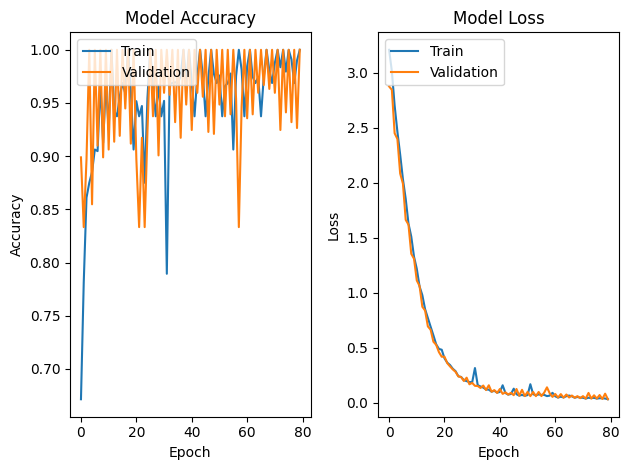

In [40]:
# Plot accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()

In [41]:
# Evaluasi model pada test set
print("\nEvaluasi model pada test set:")
results = model.evaluate(test_generator, steps=test_steps)

# Hasil evaluasi
print(f"Test Loss: {results[0]:.4f}")          # Loss
print(f"Test Accuracy: {results[1]:.4f}")      # Accuracy
print(f"Test Precision: {results[2]:.4f}")     # Precision
print(f"Test Recall: {results[3]:.4f}")        # Recall



Evaluasi model pada test set:
17/17 ━━━━━━━━━━━━━━━━━━━━ 5s 258ms/step - accuracy: 0.9266 - loss: 0.0696 - precision: 0.9417 - recall: 0.9206
Test Loss: 0.0551
Test Accuracy: 0.9596
Test Precision: 0.9665
Test Recall: 0.9559



Membuat prediksi...
17/17 ━━━━━━━━━━━━━━━━━━━━ 9s 156ms/step

Classification Report:
                      precision    recall  f1-score   support

                Acne       1.00      0.85      0.92        48
Basal Cell Carcinoma       0.97      0.78      0.87        37
           Carcinoma       1.00      0.99      0.99        83
              Eczema       0.84      1.00      0.91        76
           Keratosis       1.00      1.00      1.00        71
            Melanoma       1.00      1.00      1.00        26
               Milia       0.98      1.00      0.99        80
            Ringworm       0.93      1.00      0.96        13
             Rosacea       0.92      0.97      0.95        37
            Vitiligo       1.00      0.93      0.96        73

            accuracy                           0.96       544
           macro avg       0.96      0.95      0.96       544
        weighted avg       0.96      0.96      0.96       544



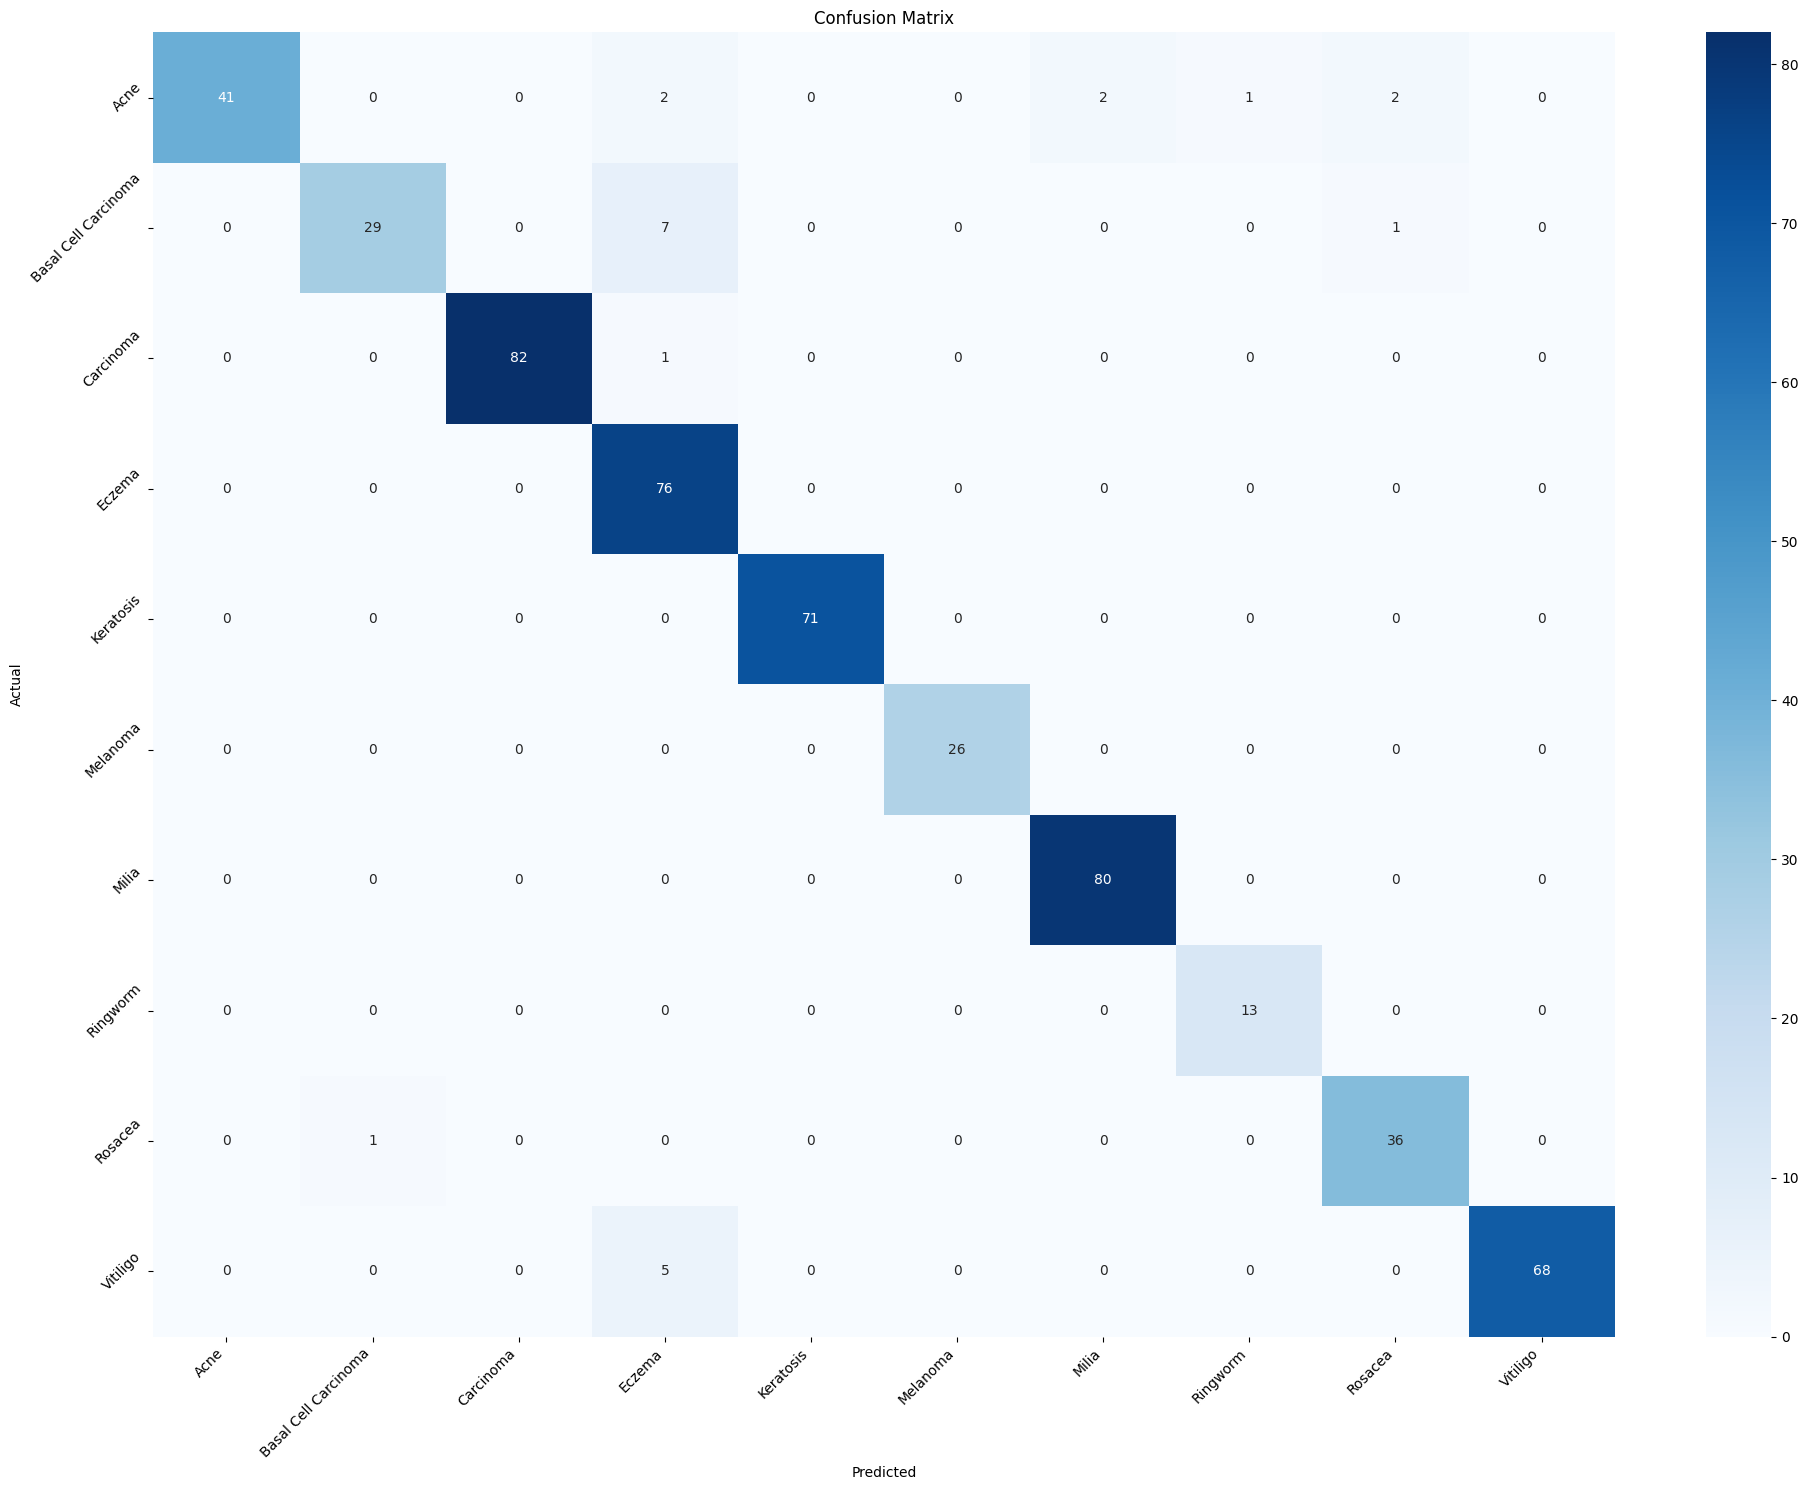


Metrik per kelas:
Acne: 0.8542
Basal Cell Carcinoma: 0.7838
Carcinoma: 0.9880
Eczema: 1.0000
Keratosis: 1.0000
Melanoma: 1.0000
Milia: 1.0000
Ringworm: 1.0000
Rosacea: 0.9730
Vitiligo: 0.9315


In [42]:
# Reset test generator untuk memastikan konsistensi
test_generator.reset()

# Prediksi pada test set
print("\nMembuat prediksi...")
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Dapatkan true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Validasi panjang array
assert len(true_classes) == len(predicted_classes), \
    f"Panjang tidak sesuai: true_classes={len(true_classes)}, predicted_classes={len(predicted_classes)}"

# Classification report
print("\nClassification Report:")
print(classification_report(true_classes, predicted_classes, target_names=class_labels))

# Confusion Matrix
plt.figure(figsize=(20, 15))
cm = confusion_matrix(true_classes, predicted_classes)
sns.heatmap(cm,
            annot=True,
            fmt='g',
            cmap='Blues',
            xticklabels=class_labels,
            yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=45)
plt.tight_layout()

# Simpan confusion matrix
plt.savefig(os.path.join(MODEL_PATH, 'confusion_matrix.png'))
plt.show()

# Tampilkan metrik per kelas
print("\nMetrik per kelas:")
for i, class_name in enumerate(class_labels):
    class_predictions = predicted_classes == i
    class_true = true_classes == i
    class_accuracy = np.sum(class_predictions & class_true) / np.sum(class_true)
    print(f"{class_name}: {class_accuracy:.4f}")


In [43]:
# Konversi model ke JSON
model_json = model.to_json()

# Simpan model JSON
json_file_path = os.path.join(MODEL_PATH, 'ensemble_model.json')
with open(json_file_path, "w") as json_file:
    json_file.write(model_json)

print("Model berhasil dikonversi ke JSON dan disimpan di:", json_file_path)


Model berhasil dikonversi ke JSON dan disimpan di: /home/labjar/alov/bangkit/skin_disease_model_efficientnetv2fulldata/ensemble_model.json
